In [44]:
# import sys
# !{sys.executable} -m pip install --user plotly.express
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway, pearsonr
import numpy as np

In [45]:
# Load the CSV data
df = pd.read_csv('cleaned_heart_disease_kmodes.csv')
# df = pd.read_csv('cleaned_heart_disease_majority.csv')
# df = pd.read_csv('heart_disease_remove_empty.csv')
numerical_vars = [
    "Age", "Blood Pressure", "Cholesterol Level", "BMI", "Sleep Hours", 
    "Triglyceride Level", "Fasting Blood Sugar", "CRP Level", "Homocysteine Level"
]

categorical_vars = [
    'Gender', 'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes', 'High Blood Pressure', 
    'Low HDL Cholesterol', 'High LDL Cholesterol', 'Alcohol Consumption', 'Stress Level', 'Sugar Consumption'
    ]

## For statistical Analysis:

numerical vs numericla: pearson correlation

numericla vs categorical: one way ANOVA

categorical vs categorical: chi-square

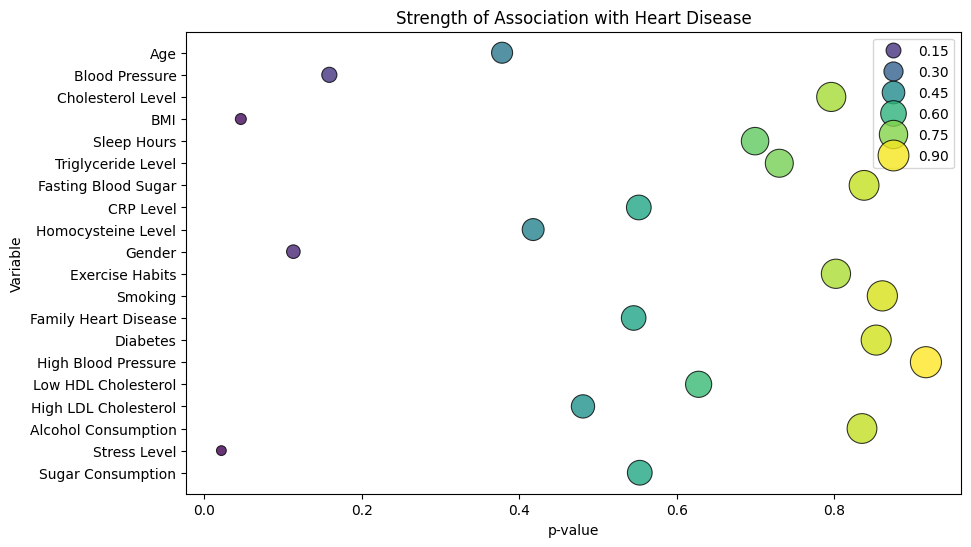

In [49]:
results = []

if df['Heart Disease Status'].dtype == 'O':
    df['Heart Disease Status'] = df['Heart Disease Status'].map({'Yes': 1, 'No': 0})

for var in numerical_vars:
    group_w_hd = df[df["Heart Disease Status"] == 1][var]
    group_wo_hd = df[df["Heart Disease Status"] == 0][var]
    
    # Only perform test if both groups have data
    if len(group_w_hd) > 1 and len(group_w_hd) > 1:
        f_stat, p_val = f_oneway(group_w_hd, group_wo_hd)
        results.append({
            "Variable": var,
            "Test": "ANOVA",
            "p-value": p_val
        })

# For categorical variables, perform a chi-square test.
for var in categorical_vars:
    # Create contingency table between the factor and Heart Disease Status
    contingency = pd.crosstab(df[var], df["Heart Disease Status"])
    if contingency.shape[0] > 1 and contingency.shape[1] > 1:
        chi2, p_val, dof, expected = chi2_contingency(contingency)
        results.append({
            "Variable": var,
            "Test": "chi-square",
            "p-value": p_val
        })

# Convert results to a DataFrame.
results_df_fac = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_fac, x="p-value", y="Variable", size="p-value", hue="p-value",
                sizes=(50, 500), palette="viridis", edgecolor="black", alpha=0.8)
plt.xlabel("p-value")
plt.title("Strength of Association with Heart Disease")
plt.legend()
plt.show()


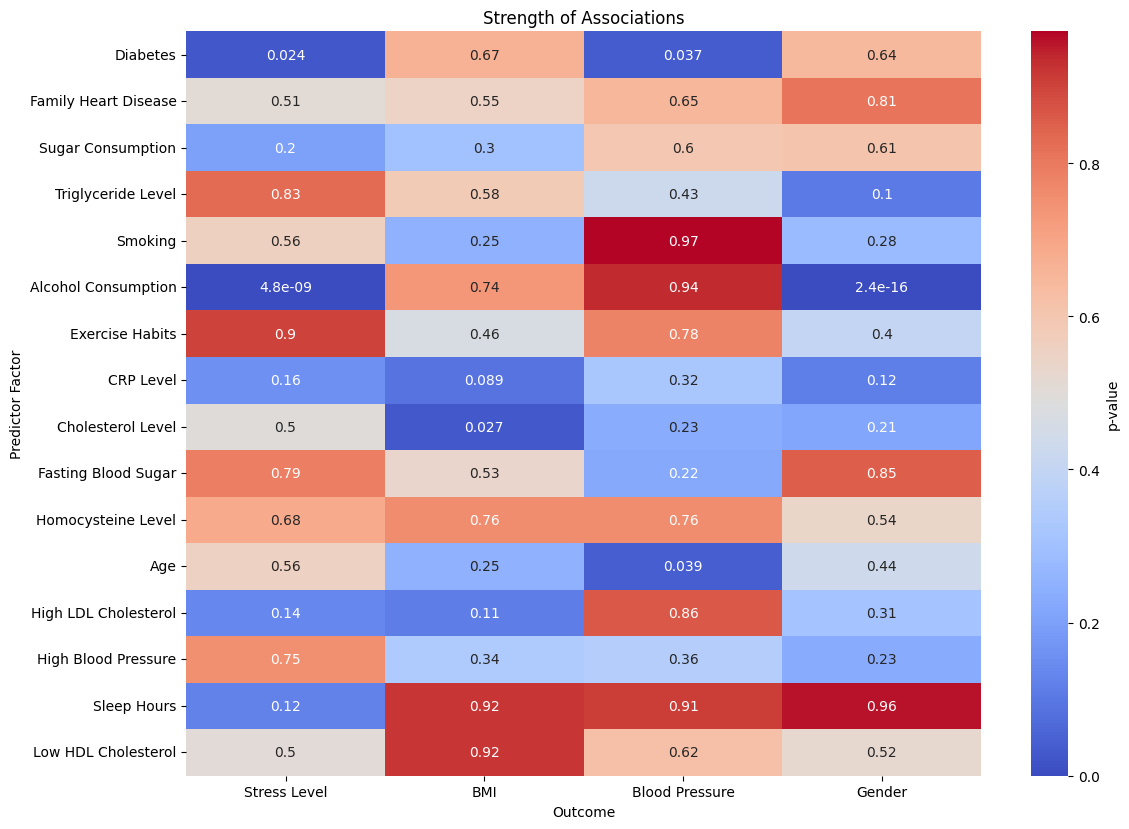

In [50]:
outcomes = ["Stress Level", "BMI", "Blood Pressure","Gender"]

# Exclude the outcomes themselves
predictors = list(set(numerical_vars + categorical_vars))
for outcome in outcomes:
    if outcome in predictors:
        predictors.remove(outcome)

# Initialize a dictionary to store p-values.
association_results = {outcome: {} for outcome in outcomes}

for outcome in outcomes:
    for factor in predictors:
        # --- For Stress Level (categorical) ---
        if outcome == "Stress Level" or outcome == "Gender":
            if df[factor].dtype in ['object', 'category']:
                # Both categorical: chi-square
                contingency = pd.crosstab(df[factor], df[outcome])
                chi2, p_val, dof, expected = chi2_contingency(contingency)
                association_results[outcome][factor] = p_val
            else:
                # Numerical: one-way ANOVA across stress level groups.
                groups = [df[df[outcome] == level][factor] for level in df[outcome].unique()]
                f_stat, p_val = f_oneway(*groups)
                association_results[outcome][factor] = p_val


        # --- For BMI and Blood Pressure(numerical) ---
        else:
            if df[factor].dtype not in ['object', 'category']:
                # Both numerical: Pearson correlation.
                data = df[[factor, outcome]]
                r, p_val = pearsonr(data[factor], data[outcome])
                association_results[outcome][factor] = p_val
            else:
                # Categorical: one-way ANOVA comparing outcome across categories.
                groups = [df[df[factor] == level][outcome] for level in df[factor].unique()]
                f_stat, p_val = f_oneway(*groups)
                association_results[outcome][factor] = p_val


# Create a DataFrame from the results dictionary.
assoc_df = pd.DataFrame(association_results)

# Convert p-values to -log10(p-value) for visualization.
assoc_df_log = -np.log10(assoc_df)

# Plot the heatmap.
plt.figure(figsize=(12, len(assoc_df_log)*0.4 + 2))
sns.heatmap(assoc_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'p-value'})
plt.title("Strength of Associations")
plt.xlabel("Outcome")
plt.ylabel("Predictor Factor")
plt.tight_layout()
plt.show()

C:\Users\zqy15\AppData\Local\Temp\ipykernel_11284\64449095.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="neg_log10_p", y="Variable", data=results_df_al, palette=colors)


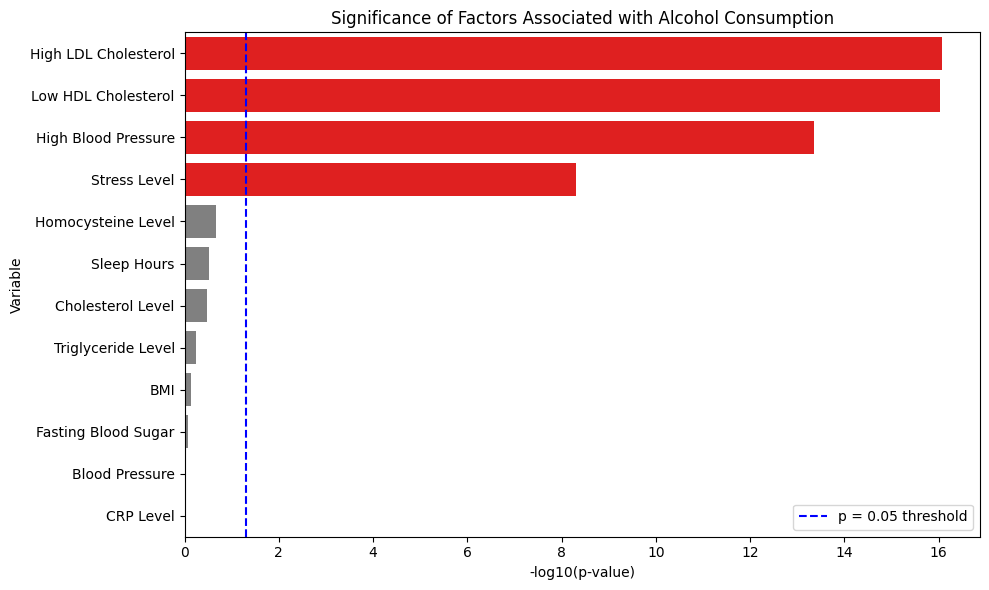

In [47]:
'''alcohol consumption can affect what'''

numerical_vars_al = [
    "Blood Pressure", "Cholesterol Level", "BMI", "Sleep Hours", 
    "Triglyceride Level", "Fasting Blood Sugar", "CRP Level", "Homocysteine Level"
]

categorical_vars_al = ['High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol', 'Stress Level']
results_cont = []
# Evaluate continuous variables using one-way ANOVA across different alcohol consumption groups
for var in numerical_vars_al:
    # Get the groups by alcohol consumption level
    groups = [group[var] for name, group in df.groupby('Alcohol Consumption')]
    if len(groups) > 1:  # Only if there are at least 2 groups
        f_stat, p_val = f_oneway(*groups)
        results_cont.append({
            "Variable": var,
            "Test": "ANOVA",
            "Statistic": f_stat,
            "p-value": p_val
        })

results_cat = []
# Evaluate categorical variables using a chi-square test
for var in categorical_vars_al:
    contingency = pd.crosstab(df[var], df['Alcohol Consumption'])
    chi2, p_val, dof, expected = chi2_contingency(contingency)
    results_cat.append({
        "Variable": var,
        "Test": "Chi-square",
        "Statistic": chi2,
        "p-value": p_val
    })

# Combine the results into one DataFrame
results_df_al = pd.DataFrame(results_cont + results_cat)

# Calculate -log10(p-value) for easier visualization (larger values = more significant)
results_df_al["neg_log10_p"] = -np.log10(results_df_al["p-value"])

# Flag significant factors (p < 0.05)
results_df_al["Significant"] = results_df_al["p-value"] < 0.05

# Sort results for plotting
results_df_al = results_df_al.sort_values("neg_log10_p", ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
# Color bars red if significant, grey otherwise
colors = ["red" if sig else "grey" for sig in results_df_al["Significant"]]
sns.barplot(x="neg_log10_p", y="Variable", data=results_df_al, palette=colors)
plt.xlabel("-log10(p-value)")
plt.title("Significance of Factors Associated with Alcohol Consumption")

# Draw the significance threshold line (p=0.05 corresponds to -log10(0.05))
sig_threshold = -np.log10(0.05)
plt.axvline(x=sig_threshold, linestyle="--", color="blue", label="p = 0.05 threshold")
plt.legend()
plt.tight_layout()
plt.show()

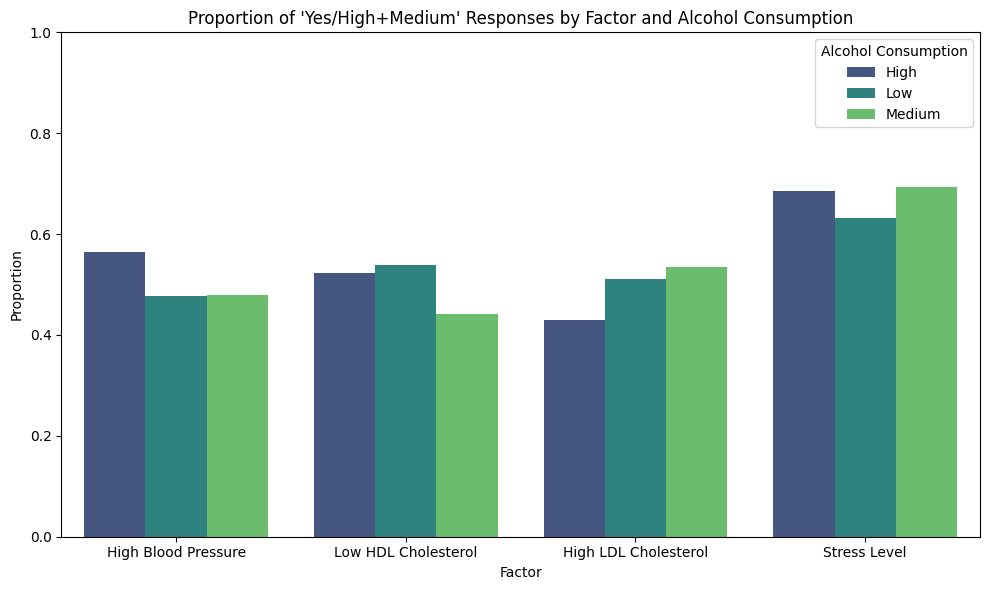

In [48]:
factors = ['High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol', 'Stress Level']

# Hold aggregated normalized data
agg_data = []

# Get the sorted unique categories for Alcohol Consumption
alc_categories = sorted(df["Alcohol Consumption"].unique())

for factor in factors:
    for alc in alc_categories:
        subset = df[df["Alcohol Consumption"] == alc]
        # Use "High" + "Medium" for Stress Level, "Yes" for others
        if factor == "Stress Level":
            # Compute proportion for stress level being either "High" or "Medium"
            proportion = ((subset[factor] == "High") | (subset[factor] == "Medium")).mean()
        else:
            # For binary factors where "Yes" indicates positive
            proportion = (subset[factor] == "Yes").mean()
        agg_data.append({
            "Factor": factor,
            "Alcohol Consumption": alc,
            "Proportion": proportion
        })

# Create a DataFrame from the aggregated data
agg_df = pd.DataFrame(agg_data)

# Plot a grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df, x="Factor", y="Proportion", hue="Alcohol Consumption", palette="viridis")
plt.title("Proportion of 'Yes/High+Medium' Responses by Factor and Alcohol Consumption")
plt.xlabel("Factor")
plt.ylabel("Proportion")
plt.ylim(0, 1)
plt.legend(title="Alcohol Consumption", loc="upper right")
plt.tight_layout()
plt.show()